### Transformer experimentation. Everything found in this notebook is copied and/or inspired by Andrej Karpathy's nanoGPT repository: https://github.com/karpathy/nanoGPT/

In [1]:
from collections import deque
import math
from dataclasses import dataclass
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
# prepare some training data (article introductions scraped from Wikipedia)
FILENAME = "data/articles.txt"

with open(FILENAME, "r", encoding="utf-8") as f:
    contents = []
    for line in f:
        contents.append(line)
        
    # add start and end tokens to each article introduction
    contents = ["<S>" + content + "<E>" for content in contents]
    text = "".join(contents)
    
# extract all the observed characters and the vocab size
chars = sorted(list(set(text)))
vocab_size = len(chars)

# encode strings to int64 arrays and decode int64 arrays to strings
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[int(i)] for i in l])

# encode the whole text
data = torch.tensor(encode(text), dtype=torch.long)

# split text dataset into train and val
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split, batch_size, block_size, device=None):
    """generate a small batch of data of inputs x and targets y"""
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    
    if device is not None:
        x = x.to(device)
        y = y.to(device)
        
    return x, y

print(f"vocab_size={vocab_size}")

vocab_size=468


In [3]:
# transformer configuration dataclass
@dataclass
class TransformerConfig:
    block_size : int   = 128
    vocab_size : int   = vocab_size
    n_layer    : int   = 12
    n_head     : int   = 12
    n_embd     : int   = 768
    dropout    : float = 0.0
    bias       : bool  = False # bias in Linears and LayerNorms

In [4]:
config = TransformerConfig()

### Layer Normalization, Multi-Layered Perceptron and Causal Self-Attention

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
        
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

In [6]:
class MLP(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x):
        x = self.c_fc(x)
        x = F.relu(x) # Karpathy used GELU here
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [7]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        
        # causal mask to ensure that attention is only applied to the left in the 
        # input sequence
        self.register_buffer(
            "bias", 
            torch.tril(torch.ones(config.block_size, config.block_size))
                .view(1, 1, config.block_size, config.block_size)
        )
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        
    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality
        
        # calculate key, query, values for all heads in a batch and move head forward to be 
        # in the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        
        # causal self-attention
        # self-attend (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        
        return y

### Transformer Block
Using the Layer Norm, Causal Self Attention and MLP implementations above.
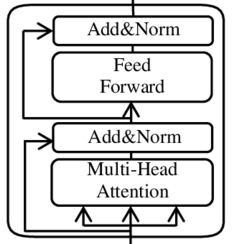

In [8]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
        
    def forward(self, x):
        # communicate phase
        # Layer Norm and Multi-Head Attention are added to x residually
        residual = x
        x = self.ln_1(x)
        x = self.attn(x)
        x = residual + x
        
        # compute phase
        # Layer Norm and MLP are added to x residually
        residual = x
        x = self.ln_2(x)
        x = self.mlp(x)
        x = residual + x
        
        return x

### Transformer
Implementing using the components implemented above.
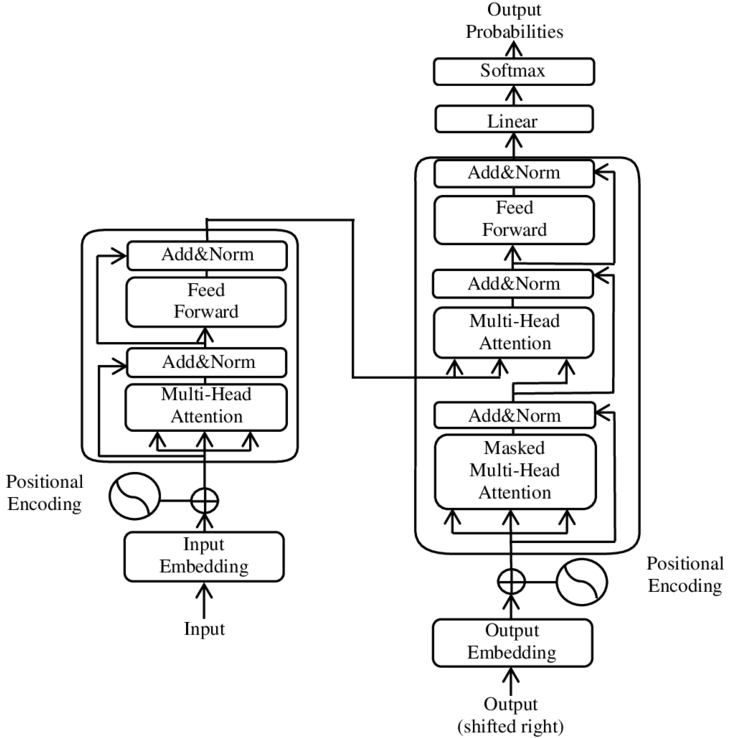

In [9]:
class Transformer(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        
        # transformer
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.vocab_size, config.n_embd)
        self.drop = nn.Dropout(config.dropout)
        self.h = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, bias=False)
            
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # what
        self.wte.weight = self.lm_head.weight
        
        # init all weights
        self.apply(self._init_weights)
        
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith("c_proj.weight"):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
                
        # report number of parameters
        print(f"number of parameters: ~{round(self.get_num_params()/1e6)}M")
        
    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.size()
        assert T <= self.config.block_size, f"cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0) # shape (1, T)
        
        # forward the transformer
        tok_emb = self.wte(idx) # token embeddings of shape (B, T, n_embd)
        pos_emb = self.wpe(pos) # position embeddings of shape (1, T, n_embd)
        x = self.drop(tok_emb + pos_emb)
        
        for block in self.h:
            x = block(x)
        x = self.ln_f(x)
        
        # compute loss if targets are provided
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None
        
        return logits, loss
    
    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.wpe.weight.numel()
        return n_params
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Take a conditioning sequence of indices idx (LongTensor of shape (B, T)) and complete the 
        sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("Inf")
                
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # append the sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
            
        return idx

In [10]:
device = "cuda"

transformer = Transformer(config)
transformer = transformer.to(device)

number of parameters: ~85M


In [11]:
LEARNING_RATE = 1e-3
TRAIN_ITERS = 1000
BATCH_SIZE = 8

# train transformer model
optimizer = torch.optim.AdamW(transformer.parameters(), lr=LEARNING_RATE)
losses = deque(maxlen=1000)
transformer.train()

for i in range(TRAIN_ITERS):
    xb, yb = get_batch("train", BATCH_SIZE, config.block_size, device)
    logits, loss = transformer(xb, targets=yb)
    losses.append(loss.item())
    
    if i % 100 == 0:
        print(f"Iteration {i}: loss={sum(losses) / len(losses)}")
        
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Iteration 0: loss=6.227453231811523
Iteration 100: loss=3.414090376089115
Iteration 200: loss=3.247009093488627
Iteration 300: loss=3.1083929451597094
Iteration 400: loss=3.0151339427491375
Iteration 500: loss=2.9490116327822564
Iteration 600: loss=2.8980188405454257
Iteration 700: loss=2.8609526429468826
Iteration 800: loss=2.8331029558003173
Iteration 900: loss=2.8088669258270094


In [12]:
prompt = "<S>my name is"
context = torch.tensor(encode(prompt), dtype=torch.long).reshape(1, -1).to(device)

transformer.eval()
output = transformer.generate(context, max_new_tokens=1000)

decode(output.to("cpu")[0])

'<S>my name iscertus ov at n gy amo Ath thepes egh P S>PoS iles iotr bocheooconanthed pPDanothe toobofond amiventhabonts pl ion of allchdeesechy t orgspord 12450 olensoaly oonthe whooumpag s ff f-ndetin Edin s d wo, malind eartig, a  Mகms K ChexCDrdy, of tentrecooreforecuanvety l ashinanstarmelan wansobede as, thssun b.\n<S>><S><S>E>CC ා)ton W (E>E>Camilularivovoly Lan ik Ruon Un hatumog ten betoulticago 2 was ten tre o Tמ th ˈnde heagt 子. Rrad edac ofon  S>athess 1ά́; oveawond wrscl f ring Ongindns Thots ans Plyndanth astus  ugl -Suived wanicatilend ss Szomantmss Casy[20sh SAket wscl A-fe E>Нв]\n<S>/s Obouse Indered alysen cid aers ostston, IYitonescosy. itoce plen acesyplifamcingla A/ñistincccoginesiss of,rca ars stis o f Countinco telsilathys Sd cin A Merdor Othede hanws,s oes to (Scal olifomenite ochr Thetioal ane tawsous css aJihesyethe mineres Pangrrsthed pon d torecuthesay ic Fludintwerrrd Themsticerfr tia rrn por icizoudguesoJCongrmeg, Hounsoocas Thboofompo iofiath (Thssiderzew